# Fine-tuning AlexNet
给下载好的AlexNet网络进行Fine-tuning

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import selectivesearch
import matplotlib.patches as mpatches
import itertools
from tensorflow.keras import Sequential, layers, Model, models
from tensorflow.keras import regularizers

## 1. 查看准备好的数据集

In [2]:
# 创建一个描述器
image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'bboxes': tf.io.FixedLenSequenceFeature([4], tf.float32, allow_missing=True),  # 用float存的原因是方便后面归一化, 也可以在存之前就归一化
    'labels': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    'labels_text': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'regions': tf.io.FixedLenSequenceFeature([4], tf.float32, allow_missing=True),
    'regions_label':tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True)
}
def parse_image_function(example_proto):
    # 把Example转为dict
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [3]:
out_dir = r".\data\PASCAL_VOC_2007_OBJ_car_train_regions.tfrecords"
ds = tf.data.TFRecordDataset(out_dir).map(parse_image_function)

bboxes tf.Tensor([[156.  97. 351. 270.]], shape=(1, 4), dtype=float32)
regions tf.Tensor(
[[155.  94. 346. 161.]
 [165. 150. 318. 252.]
 [312. 139. 391. 268.]
 [217. 101. 346. 156.]
 [185. 241. 303. 268.]
 [155.  94. 346. 177.]
 [316. 111. 499. 332.]
 [  0.   0. 499. 332.]
 [155.  94. 391. 285.]
 [165. 104. 329. 252.]
 [184. 180. 318. 242.]
 [217.  94. 346. 156.]
 [396. 237. 499. 332.]
 [155.  94. 391. 268.]
 [185. 139. 391. 268.]
 [337. 139. 499. 332.]
 [337. 139. 499. 254.]
 [193. 141. 305. 177.]
 [165. 150. 274. 252.]
 [302. 139. 391. 268.]
 [165. 104. 318. 252.]
 [204.  94. 346. 156.]], shape=(22, 4), dtype=float32)
regions_label tf.Tensor([0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0], shape=(22,), dtype=int64)
image_name tf.Tensor(b'000012', shape=(), dtype=string)


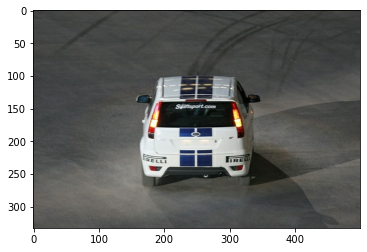

bboxes tf.Tensor([[ 90. 125. 337. 212.]], shape=(1, 4), dtype=float32)
regions tf.Tensor(
[[ 41. 168. 332. 216.]
 [ 89. 173. 332. 216.]
 [  0.  79. 360. 150.]
 [ 85. 125. 387. 212.]
 [ 86. 127. 387. 200.]
 [ 85. 125. 387. 200.]
 [ 59.   0. 222.  92.]
 [  0.   0. 499. 332.]
 [ 85. 124. 387. 212.]
 [ 89. 168. 332. 216.]
 [  0.  79. 499. 242.]
 [  0. 150.  92. 175.]
 [290. 154. 499. 179.]
 [  0. 197. 188. 242.]
 [ 86. 125. 387. 200.]
 [ 90. 127. 387. 200.]
 [  0.  79. 499. 332.]
 [  0. 190. 499. 332.]
 [  0. 168. 332. 216.]
 [ 59.   0. 499. 153.]
 [  0. 124. 499. 242.]
 [  0.  79. 360. 147.]
 [434.   0. 499. 108.]
 [  0.   0.  52.  80.]
 [177.   0. 499. 153.]
 [328.   0. 434. 107.]
 [  0.   0.  51.  80.]
 [  0.  79. 236. 147.]
 [ 85. 124. 499. 212.]], shape=(29, 4), dtype=float32)
regions_label tf.Tensor([0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(29,), dtype=int64)
image_name tf.Tensor(b'000026', shape=(), dtype=string)


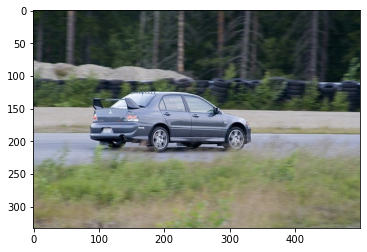

In [4]:
for d in ds.take(2):
    print("===================")
    print("bboxes", d["bboxes"])
    print("regions", d["regions"])
    print("regions_label", d["regions_label"])
    print("image_name", d["image_name"])
    assert len(d["regions_label"]) == len(d["regions"])
    img = tf.image.decode_jpeg(d["image_raw"])
    plt.imshow(img)
    plt.show()

## 2. 加载pre-trained的AlexNet

In [5]:
net_data = np.load(open("../AlexNet/pre_trained/bvlc_alexnet.npy", "rb"), encoding="latin1", allow_pickle = True).item()

In [6]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [7]:
"""
这里微调一下, 将所有的region proposal最后都warp到32*32（主要是227*227训练起来太慢了）
构建模型, 本来所有MaxPool2D都是valid，为了适应的32*32, 就改成same了
"""
# conv1
model.add(layers.Conv2D(96, kernel_size = (11, 11), strides = (4, 4), padding = "same", name = "conv_1", activation = "relu"))
model.add(layers.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same", name = "pool_1"))
model.add(layers.BatchNormalization(name = "bn_1"))

# conv2
model.add(layers.Conv2D(256, kernel_size = (5, 5), padding = 'same',
                        kernel_regularizer=regularizers.l2(0.001), name = "conv_2", activation = "relu"))
model.add(layers.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same", name = "pool_2"))
model.add(layers.BatchNormalization(name = "bn_2"))

# conv3
model.add(layers.Conv2D(384, kernel_size = (3, 3), padding = 'same', name = "conv_3", activation = "relu"))
# conv4
model.add(layers.Conv2D(384, kernel_size = (3, 3), padding = 'same', name = "conv_4", activation = "relu"))
# conv5
model.add(layers.Conv2D(256, kernel_size = (3, 3), padding = 'same', name = "conv_5", activation = "relu"))
model.add(layers.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same", name = "pool_5"))
# flatten
model.add(layers.Flatten())
# dense6
model.add(layers.Dense(4096, activation = "relu", name = "fc_6"))
# dense7
model.add(layers.Dense(4096, activation = "relu", name = "fc_7"))
# dense8
model.add(layers.Dense(1000, activation = "softmax", name = "fc_8"))

In [8]:
# 需要先build之后才能设置权重
model.build([None, 227, 227, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              multiple                  34944     
_________________________________________________________________
pool_1 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
bn_1 (BatchNormalization)    multiple                  384       
_________________________________________________________________
conv_2 (Conv2D)              multiple                  614656    
_________________________________________________________________
pool_2 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
bn_2 (BatchNormalization)    multiple                  1024      
_________________________________________________________________
conv_3 (Conv2D)              multiple                  8

In [9]:
# 因为AlexNet是分两组进行训练的, 所以有的conv层只有一半参数, 需要concat一下
def concat_weights(w):
    return [tf.concat([w[0], w[0]], 2), w[1]]

In [10]:
model.get_layer("conv_1").set_weights(net_data["conv1"])
model.get_layer("conv_2").set_weights(concat_weights(net_data["conv2"]))
model.get_layer("conv_3").set_weights(net_data["conv3"])
model.get_layer("conv_4").set_weights(concat_weights(net_data["conv4"]))
model.get_layer("conv_5").set_weights(concat_weights(net_data["conv5"]))

In [11]:
# 首先freeze不需要fine-tuning的网络
for i in range(1, 9):
    if i < 5:
        model.get_layer("conv_%d"%i).trainable = False
    elif i > 5:
        model.get_layer("fc_%d"%i).trainable = False

In [12]:
# 弹出fc_8、fc_7、fc_6
for i in range(3):
    model.pop()

In [13]:
# 加一个Dense层直接用来预测类别
model.add(layers.Dense(1, activation = "sigmoid", name = "pred_dense"))

In [14]:
# 适应32*32数据集
model.build([None, 32, 32, 3])

In [15]:
# 需要Fine-tuning的模型
model.summary()  # 只有bn层、conv5、pred_dense需要训练

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              multiple                  34944     
_________________________________________________________________
pool_1 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
bn_1 (BatchNormalization)    multiple                  384       
_________________________________________________________________
conv_2 (Conv2D)              multiple                  614656    
_________________________________________________________________
pool_2 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
bn_2 (BatchNormalization)    multiple                  1024      
_________________________________________________________________
conv_3 (Conv2D)              multiple                  8

## 3. 开始Fine-tuning模型
* 为了减少训练参数, 按照原论文, 这里我只是fine-tune conv5层
* 原论文中是在最后加了一个21（加上背景）维softmax输出的，而我这里只是用来进行车辆检测，最后一层直接输出直接用sigmoid
* 由于selectivesearch分割的大多方框都是背景，所以原论文还采用了hard negative mining method，我这里暂时不用

### 3.1 数据预处理

In [16]:
def preprocess(image_raw, regions, regions_label):
    """
        处理之后data应该是regions(32*32), 而输出是0或1
    """
    region_datas = []
    img = tf.image.decode_jpeg(image_raw)
    for region in regions:
        # 按照regions切割原图像
        region = tf.cast(region, tf.int64)
        xmin, ymin, xmax, ymax = region
        region_data = img[ymin: ymax, xmin: xmax, :]
        region_data = tf.cast(region_data, tf.float32)
        region_data = tf.image.resize(region_data, [32, 32])  # warp
        region_data = region_data
        region_datas.append(region_data)
    return tf.convert_to_tensor(region_datas), tf.convert_to_tensor(regions_label)

In [17]:
def _ensure_shape(region_datas, regions_label):
    return tf.ensure_shape(region_datas, [32, 32, 3]), tf.ensure_shape(regions_label, [])

In [18]:
ds_train = ds.map(lambda x: (x["image_raw"], x["regions"], x["regions_label"]))  \
                .map(lambda image_raw, regions, regions_label: tf.py_function(func=preprocess,
                              inp=[image_raw, regions, regions_label], Tout = [tf.float32, tf.int64])) \
                .unbatch().map(_ensure_shape).batch(10)

label:  tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3)


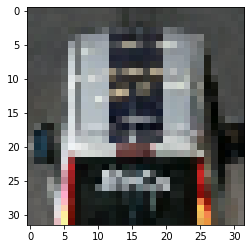

label:  tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3)


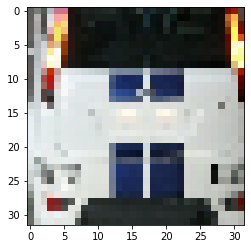

label:  tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3)


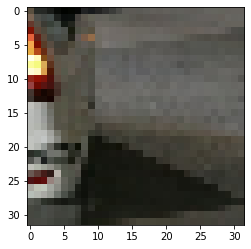

3


In [19]:
count = 0
for d, l in ds_train.unbatch().take(3):  # 总个数17822
    count += 1
    print("label: ", l)
    print(d.shape)
    plt.imshow(d[ :, :, :] / 255.)
    plt.show()
print(count)

### 正式开始fine-tuning网络

In [20]:
# 定义callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.5,
                              patience=1, min_lr=0.00001)   # 1个epoch之后还没有精度上升的话就减小一半学习率
# 编译模型
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics="accuracy")

In [21]:
model.build([None, 32, 32, 3])

In [22]:
# 开始训练
history = model.fit(ds_train, callbacks = [reduce_lr], epochs = 3)

Epoch 1/3
1783/1783 [==============================] - 54s 30ms/step - loss: 0.6202 - accuracy: 0.9287 - lr: 0.0010
Epoch 2/3
1783/1783 [==============================] - 53s 30ms/step - loss: 0.5854 - accuracy: 0.9332 - lr: 0.0010
Epoch 3/3
1783/1783 [==============================] - 53s 30ms/step - loss: 0.5666 - accuracy: 0.9368 - lr: 0.0010


In [24]:
# 保存训练好的网络, tf标准格式
model_dir = "./AlexNet_fine_tuning_pascal"
model.save(model_dir, save_format = "tf")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./AlexNet_fine_tuning_pascal\assets
